# Model Explainability and Interpretation

## Notebook Overview

In this notebook, we load the final trained model and optimal decision threshold from `03_modeling.ipynb`, and focus on interpreting the model’s predictions using SHAP (SHapley Additive exPlanations).

Our primary goals are to:

- Identify which features most strongly influence the model’s predictions.
- Understand how these influences vary globally and at the individual prediction level.
- Investigate edge cases, including high-risk or borderline predictions.
- Examine how shifting the decision threshold affects model output and interpretation.
- Communicate insights clearly for future model improvement or stakeholder use.

We use **SHAP** to generate both global feature importance plots and local explanations for selected cases. These explanations help verify the model’s logic, uncover patterns related to attrition, and identify actionable insights.

## 1. Load Final Model, Threshold, and Preprocessed Data

First, we load our trained logistic regression model and optimal classification threshold (`0.79`) from the previous modeling stage. This ensures consistency and reproducibility in our analysis.

We import the fully preprocessed dataset — engineered, scaled, and encoded — exactly as the model expects. This step sets the foundation for exploring and understanding exactly how the model makes predictions about employee attrition.

In [1]:
# === Load final model, transformed test set, and labels for SHAP analysis ===
import joblib
import pandas as pd
# === Load transformed feature names from exported JSON ===
import json
import matplotlib.pyplot as plt
import numpy as np
import joblib
import sys
sys.path.append('../src')
from feature_engineering import FeatureEngineer

# Load transformed feature names used during model evaluation
with open("../models/x_test_columns.json", "r") as f:
    transformed_feature_names = json.load(f)

# Confirm successful load
print(f"Loaded {len(transformed_feature_names)} transformed feature names.")

# Readability
import warnings
warnings.filterwarnings("ignore", message="X has feature names")

# Load trained logistic regression model
classifier = joblib.load("../models/final_model.joblib")

# Load transformed test features
X_transformed = pd.read_csv("../data/processed/x_test_transformed.csv")

# Load final test labels (binarize if necessary)
y = pd.read_csv("../data/processed/y_final_test.csv")

# Convert to binary (if still in Yes/No string format)
if y.dtypes[0] == 'object':
    y = (y == "Yes").astype(int)

# Load the fully fitted preprocessing pipeline (already fit on training data)
fitted_pipeline = joblib.load("../models/fitted_pipeline.pkl")

print("Fitted preprocessing pipeline loaded successfully.")

# Confirm shapes
print(f"Loaded model and data.")
print(f"X shape: {X_transformed.shape}, y shape: {y.shape}")

best_threshold = 0.79

Loaded 75 transformed feature names.
Fitted preprocessing pipeline loaded successfully.
Loaded model and data.
X shape: (294, 75), y shape: (294, 1)


C:\Users\justi\AppData\Local\Temp\ipykernel_5052\2630517262.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if y.dtypes[0] == 'object':


## 2. Global Feature Importance (SHAP)

With the model loaded, we now delve deeper: **What exactly is influencing the model's predictions?**  
We use SHAP values—powerful tools to quantify exactly how each feature contributes to predicting employee attrition. Let's explore this from two complementary perspectives.

### SHAP Violin Plot: Feature Impact Distribution

This beeswarm-style plot visualizes the distribution of SHAP values for each feature across individual employees. Each dot represents a single employee's SHAP value, indicating the strength and direction of a feature's influence:

- **Positive SHAP values (right)** indicate factors increasing attrition risk.
- **Negative SHAP values (left)** indicate factors reducing attrition risk.
- The **color intensity** shows feature value magnitude (red = higher, blue = lower).

**Key insights:**

- **Short Tenure (≤3 years)** and frequent **Overtime** consistently increase attrition risk. Employees newer to the organization or experiencing high workloads show a clear trend towards higher attrition probability.
- High numbers of previously worked companies (**NumCompaniesWorked**) also strongly correlate with increased risk, likely indicating lower organizational attachment.
- Features related to employee satisfaction (e.g., **SatisfactionMean**) and professional stability (e.g., **TotalWorkingYears**, **YearsCompany_Satisfaction**) predominantly reduce attrition risk, highlighting their role as protective factors.
- **Age** shows a clear protective trend—older employees are less likely to leave, indicating increasing organizational commitment or fewer career changes with age.

Overall, this visualization demonstrates nuanced individual-level variations, highlighting the diversity of risk factors across the employee population.

In [2]:
# === SHAP Explanation Setup ===
import shap
import matplotlib.pyplot as plt
from shap import LinearExplainer, summary_plot

# Initialize SHAP explainer for linear model
explainer = LinearExplainer(
    classifier,
    X_transformed,
    feature_names=transformed_feature_names
)

# Compute SHAP values
shap_values = explainer(X_transformed)

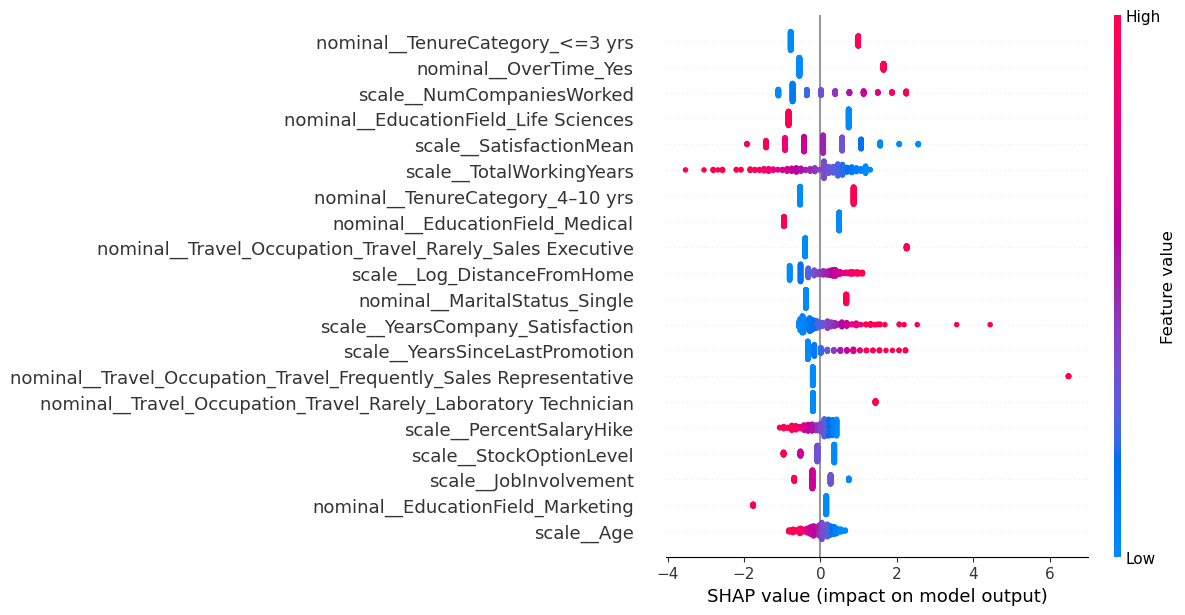

In [3]:
# === SHAP Summary Plot: Violin ===
summary_plot(
    shap_values,
    X_transformed,
    feature_names=transformed_feature_names,
    show=False
)

# Adjust layout
plt.gcf().set_size_inches(12.5, 7.5)
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.show()

### SHAP Bar Plot: Absolute Feature Importance

While the violin plot provides individual-level granularity, the bar plot aggregates SHAP values, capturing the average absolute impact of each feature on predictions—regardless of whether they increase or decrease risk:

**Key takeaways:**

- **TenureCategory (≤3 years)** emerges as the most impactful feature overall, strongly influencing attrition predictions. Shorter tenure consistently signals higher turnover likelihood, reflecting typical early-career volatility or misalignment.
- **Frequent Overtime** is also highly predictive of attrition risk, likely due to burnout, dissatisfaction, or work-life imbalance.
- Employees who've **worked at multiple companies** previously are perceived as higher attrition risks, possibly due to habitual job changes or lower commitment levels.
- Features capturing professional development and career stability (**TotalWorkingYears**, **YearsSinceLastPromotion**) significantly influence predictions, with longer tenure and recent promotions clearly indicating reduced attrition likelihood.
- Factors such as **StockOptionLevel** and **MonthlyIncome** have comparatively minor overall impact, suggesting compensation alone is less predictive of attrition compared to job satisfaction, tenure stability, or workload-related issues.

This aggregate view emphasizes consistent, broad patterns in attrition risks and highlights clear organizational focus areas for intervention, such as improving early-career experiences and managing employee workload effectively.

Together, these plots provide a comprehensive understanding of how and why the model makes its predictions, guiding targeted and strategic HR interventions.

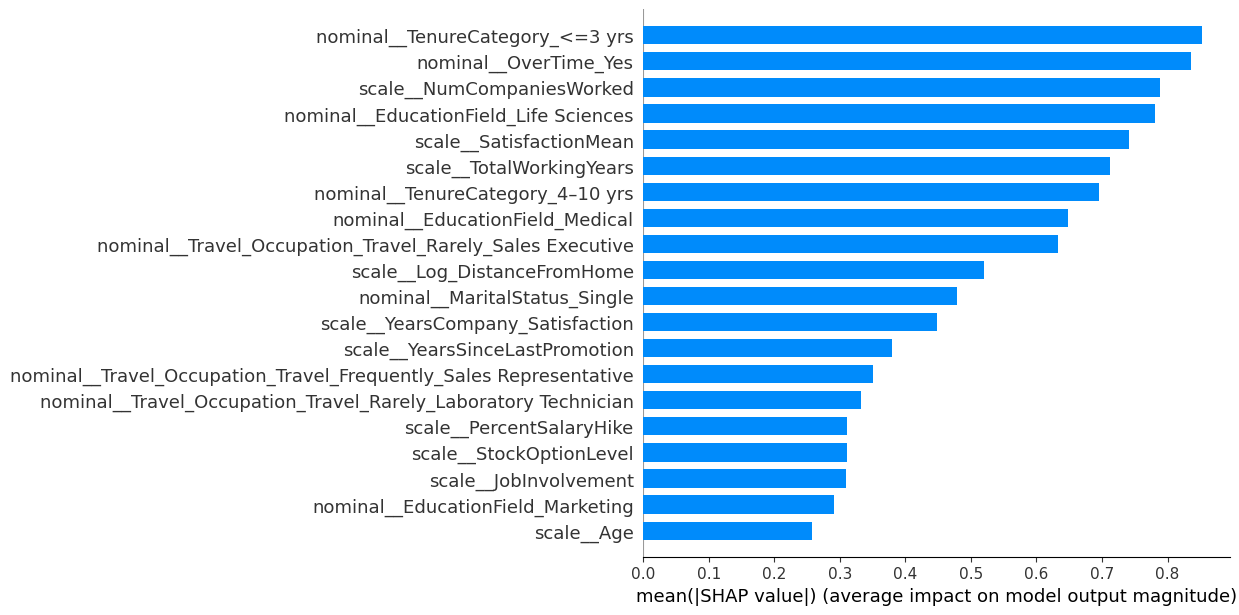

In [4]:
# === SHAP Summary Plot: Bar ===
summary_plot(
    shap_values,
    X_transformed,
    feature_names=transformed_feature_names,
    plot_type="bar",
    show=False
)

# Adjust layout
plt.gcf().set_size_inches(12.5, 7.5)
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.show()

## 3. Local Interpretation with SHAP

Shifting our focus from overall trends, we now explore **individual-level predictions**. Using SHAP waterfall plots, we gain clarity on exactly which features influenced the model's decisions in three illustrative cases:

In [18]:
# Cell 1: SHAP setup and index check
import shap
import matplotlib.pyplot as plt

# Initialize JS support (optional, for interactive notebooks)
shap.initjs()

# Confirm we have our indices
print(f"indices → high: {i_high}, borderline: {i_borderline}, low: {i_low}")


indices → high: 92, borderline: 183, low: 131


### High-Risk Case (Most Confident Prediction)

The following example illustrates how, despite having positive career aspects, intense work-related demands can decisively influence attrition predictions.

Why does the model strongly predict attrition for this employee?

- **Frequent travel in a Sales Representative role** emerges as the leading driver of attrition risk, suggesting potential burnout or dissatisfaction due to demanding travel requirements.
- **Overtime** contributes significantly, further exacerbating attrition likelihood.
- Interestingly, the employee's extensive **total working years** and relatively **high average satisfaction** act as protective factors, yet they aren't sufficient to outweigh the negative pressures from travel and overtime.


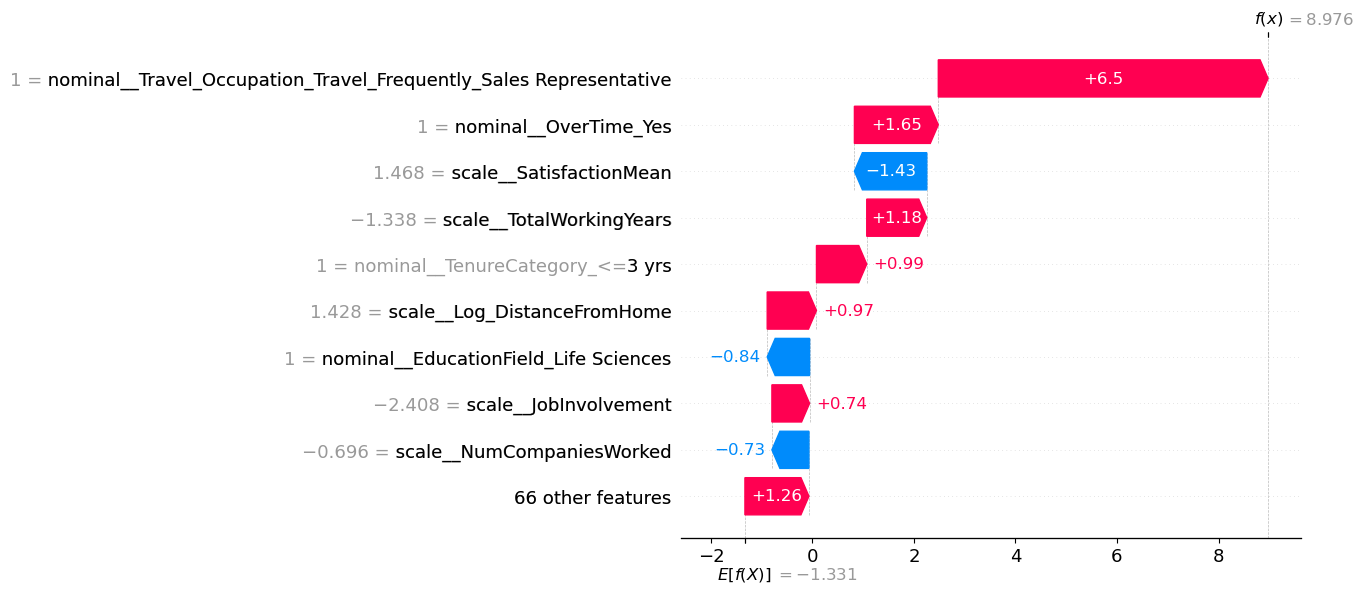

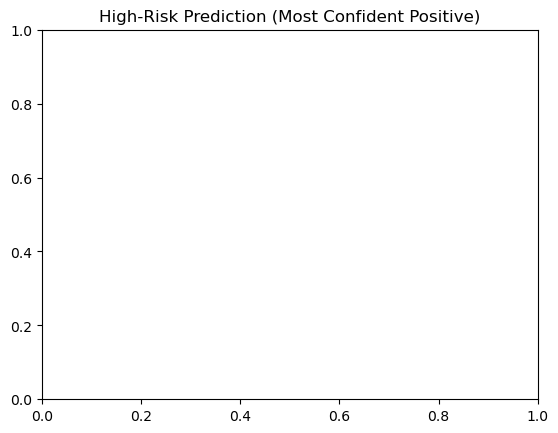

In [25]:
# Cell 2: High‐Risk Prediction (Most Confident Positive)
shap.plots.waterfall(
    shap_values[i_high],
    max_display=10  # adjust to show top N features if you like
)
plt.title("High‐Risk Prediction (Most Confident Positive)")
plt.show()


### Borderline Case (Near Threshold Prediction)

This case sits right at the decision boundary, making it an insightful scenario for understanding nuanced predictions:

- Again, **overtime** notably pushes the employee toward attrition.
- The model encounters mixed signals: moderate levels of **satisfaction** and mid-range tenure (**4–10 years**) simultaneously push toward and pull away from attrition.
- A significant **commute distance** subtly tilts the prediction towards attrition, whereas specialized education in a **Medical field** gently counters this effect.

This balanced interplay of features creates a scenario where the model's prediction is delicately poised between attrition and retention, highlighting the complexity and subtlety inherent in real-world predictions.

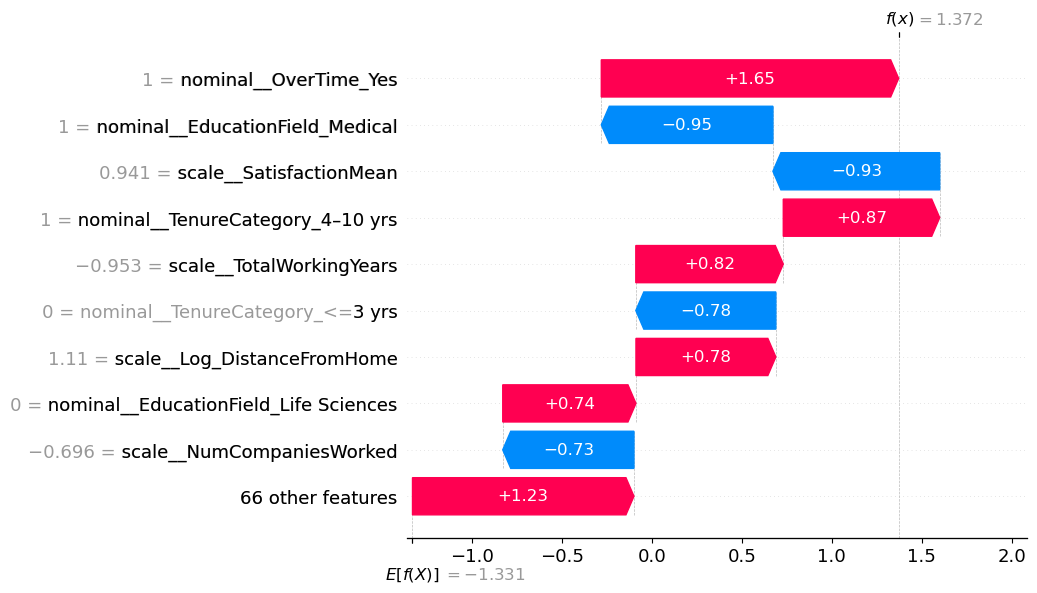

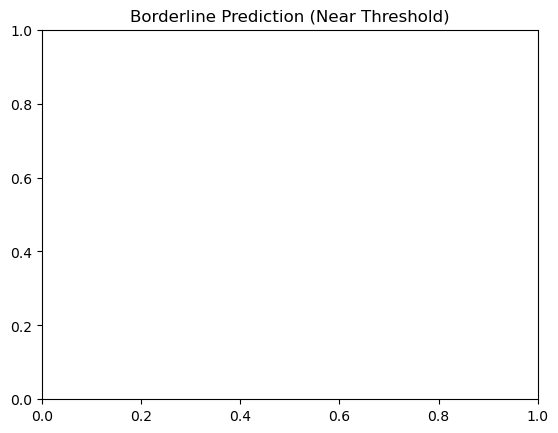

In [20]:
# Cell 3: Borderline Prediction (Near Threshold)
shap.plots.waterfall(
    shap_values[i_borderline],
    max_display=10
)
plt.title("Borderline Prediction (Near Threshold)")
plt.show()


### Low-Risk Case (Most Confident Negative Prediction)

In contrast, this employee is confidently predicted to stay—what key factors drive this clear retention signal?

- Strong indicators of professional stability—including substantial **total working years**, a managerial role involving **frequent travel**, and recent **salary increases**—collectively outweigh any potential risks.
- A shorter tenure (**≤3 years**) marginally increases attrition risk, yet this minor negative influence is effectively neutralized by stronger positive signals.
- Mild negative factors like commute distance or lack of overtime remain present but have minimal overall impact.

This scenario underscores how robust indicators of career stability and progression can decisively secure a confident retention prediction, even in the presence of some conflicting signals.

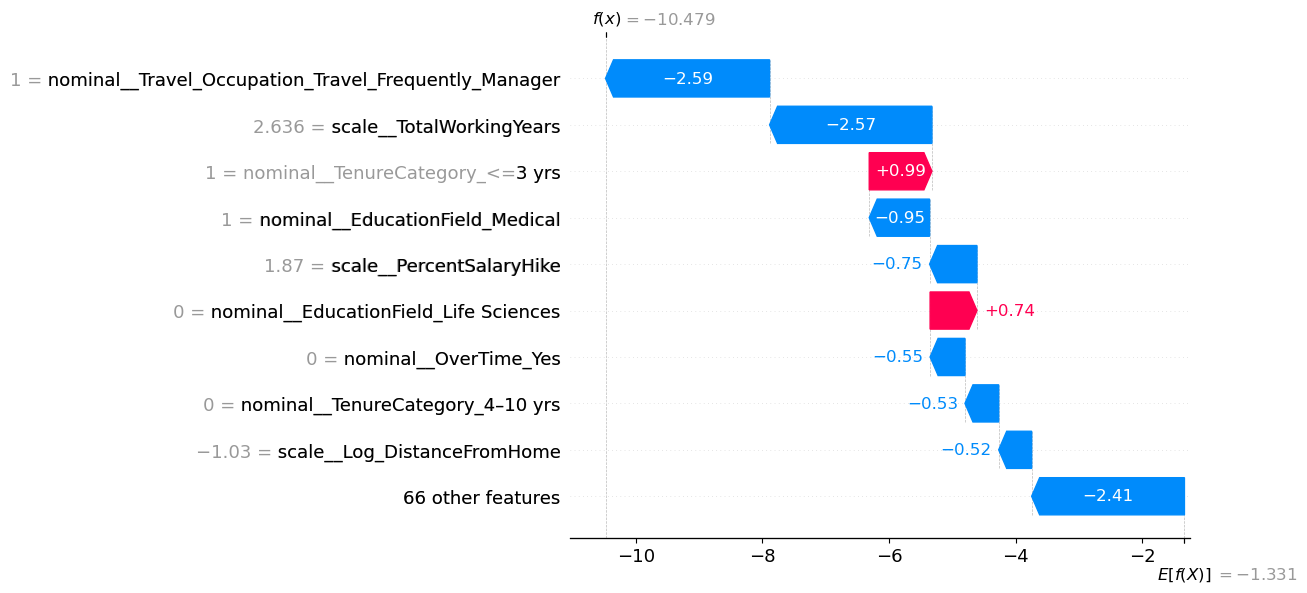

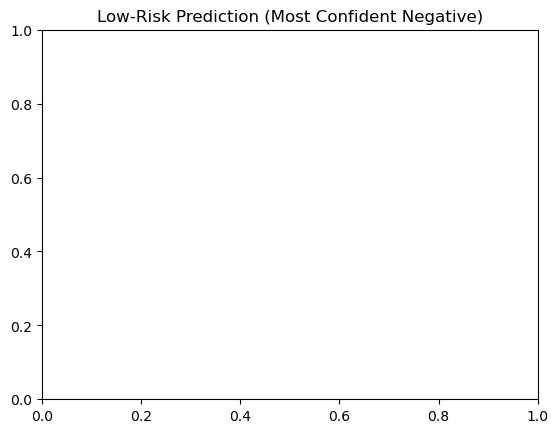

In [21]:
# Cell 4: Low‐Risk Prediction (Most Confident Negative)
shap.plots.waterfall(
    shap_values[i_low],
    max_display=10
)
plt.title("Low‐Risk Prediction (Most Confident Negative)")
plt.show()


## 4. Threshold Effects on Interpretation

This section explores how adjusting the classification threshold (e.g., from 0.5 to an optimal threshold based on F1 score) impacts both the model's performance and interpretability.

---

### 🎯 Objective

- Compare classification results at default threshold (0.5) vs. optimal threshold.
- Examine samples where predictions change due to threshold shift.
- Use SHAP to explain why the model flips a decision in these borderline cases.

---

### ⚙️ Confusion Matrix Comparison

```python
y_pred_05 = (y_prob > 0.5).astype(int)
y_pred_best = (y_prob > best_threshold).astype(int)
```

Two confusion matrices are displayed side-by-side:
- **Threshold = 0.5**: Standard binary classifier cutoff.
- **Threshold = Best**: Custom threshold maximizing validation F1 score.

This visualizes the trade-off between **false positives** and **false negatives** under different decision boundaries.

---

### 🔄 Analyzing Label Flips

```python
flipped_idx = np.where(y_pred_05 != y_pred_best)[0]
```

This identifies all test set samples whose predicted labels change when switching thresholds.

We randomly sample a few of these and print:

```python
Index: 66, Prob: 0.526, Label_0.5: 1, Label_best: 0
```

This tells us:
- The model **would have predicted attrition** at 0.5
- But under the optimal threshold, it **predicted retention**
- The SHAP waterfall plot explains **why** the output changed

---

### 📊 SHAP Waterfall Plots

We visualize the flipped samples using `shap.plots.waterfall()` to explain their predictions:

- **Red bars**: Features pushing the prediction higher (toward attrition)
- **Blue bars**: Features pushing it lower (toward retention)
- The plots start from the SHAP base value and accumulate feature contributions to reach the model's raw output `f(x)`

Example insights:
- A sample with a probability of 0.59 at threshold 0.5 may flip to class 0 under a 0.72 threshold.
- In that case, `DistanceFromHome`, `EnvironmentSatisfaction`, and `RelationshipSatisfaction` were the top drivers toward attrition, but not strong enough to overcome stabilizing factors like `JobSatisfaction` or `YearsWithCurrManager`.

---

### 🧠 Why This Matters

Threshold tuning isn’t just about performance metrics — it **changes the decision boundary**, which changes:
- **Which predictions flip**
- **Which individuals get flagged**
- **How you explain those flips**

By combining threshold logic with SHAP, we can:
- Identify edge cases that require review
- Justify model decisions under real-world constraints
- Build trust in the model's predictions and rationale

---

### ✅ Summary

This section provides a nuanced view of how **threshold selection** affects both:
1. Model **evaluation metrics**
2. Model **interpretability at the individual level**

Waterfall plots offer transparency into borderline predictions, reinforcing interpretability in operational settings.


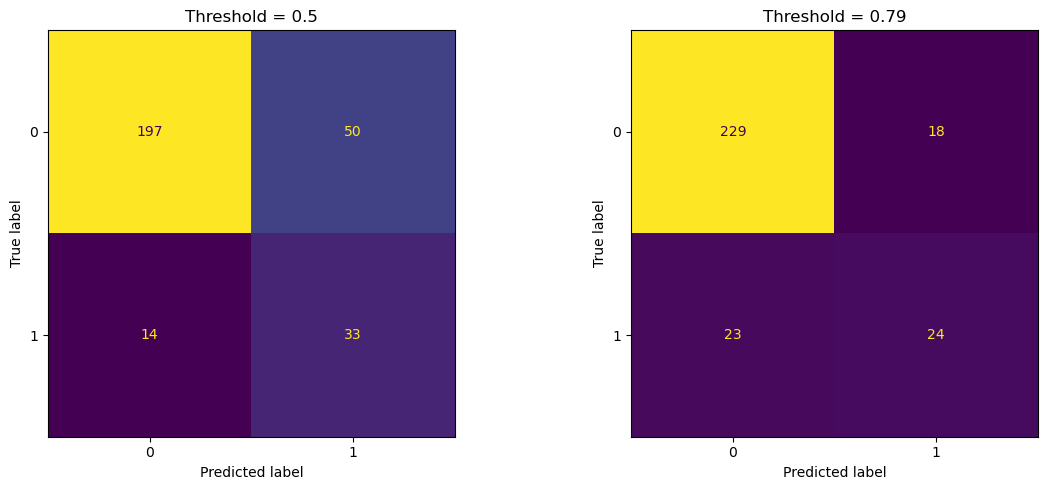

Samples with prediction changes due to threshold shift: 41


In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Predict probabilities on transformed data
y_prob = classifier.predict_proba(X_transformed)[:, 1]

# Predict using threshold 0.5 and best threshold
y_pred_05 = (y_prob >= 0.5).astype(int)
y_pred_best = (y_prob >= best_threshold).astype(int)

# Plot confusion matrices side-by-side
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
for ax, pred, title in zip(
    axs,
    [y_pred_05, y_pred_best],
    ["Threshold = 0.5", f"Threshold = {best_threshold:.2f}"]
):
    cm = confusion_matrix(y, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(title)

plt.tight_layout()
plt.show()

# Identify flipped predictions (threshold-sensitive)
flipped_idx = np.where(y_pred_05 != y_pred_best)[0]

# Sample 3 flipped predictions randomly
flipped_sample_ids = np.random.choice(flipped_idx, size=min(3, len(flipped_idx)), replace=False)
print(f"Samples with prediction changes due to threshold shift: {len(flipped_idx)}")


Index: 277, Prob: 0.607, Label @0.5: 1, Label @best: 0


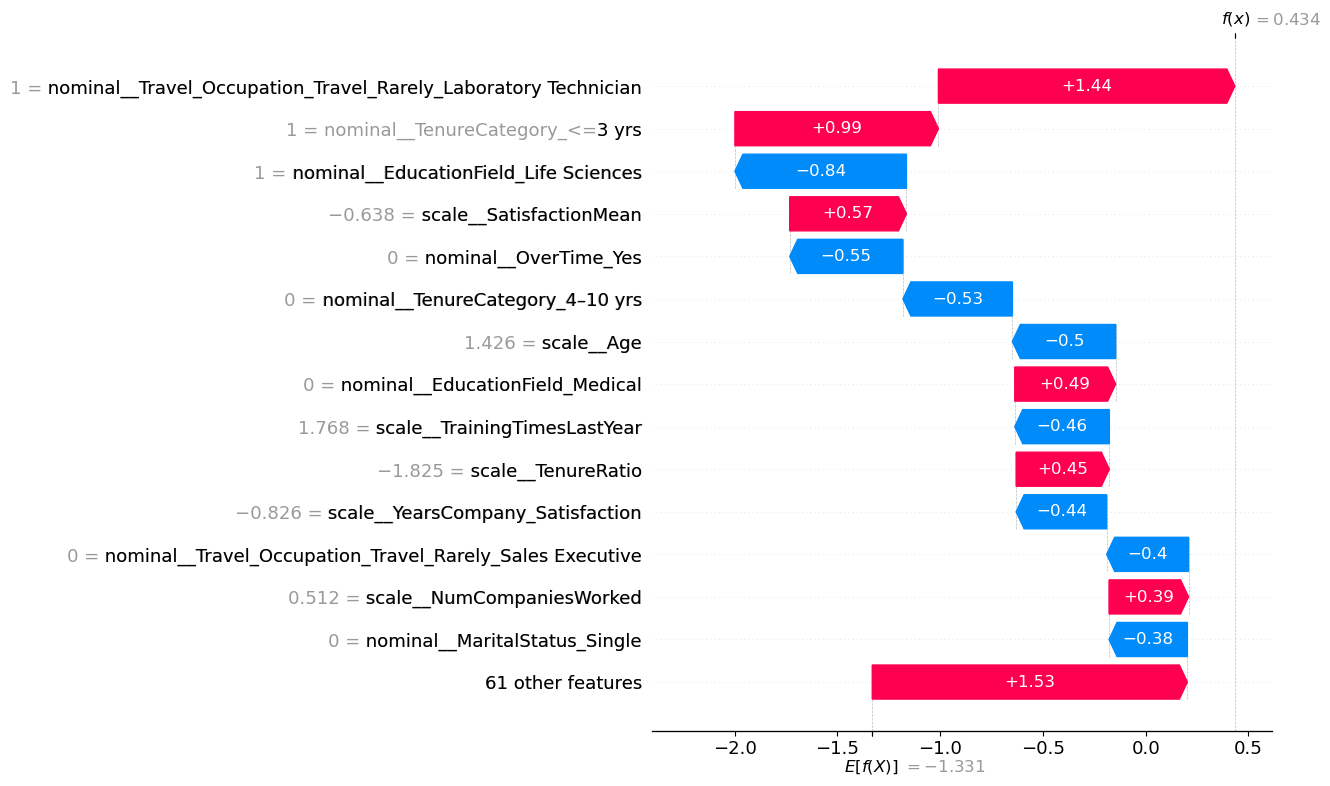

Index: 67, Prob: 0.685, Label @0.5: 1, Label @best: 0


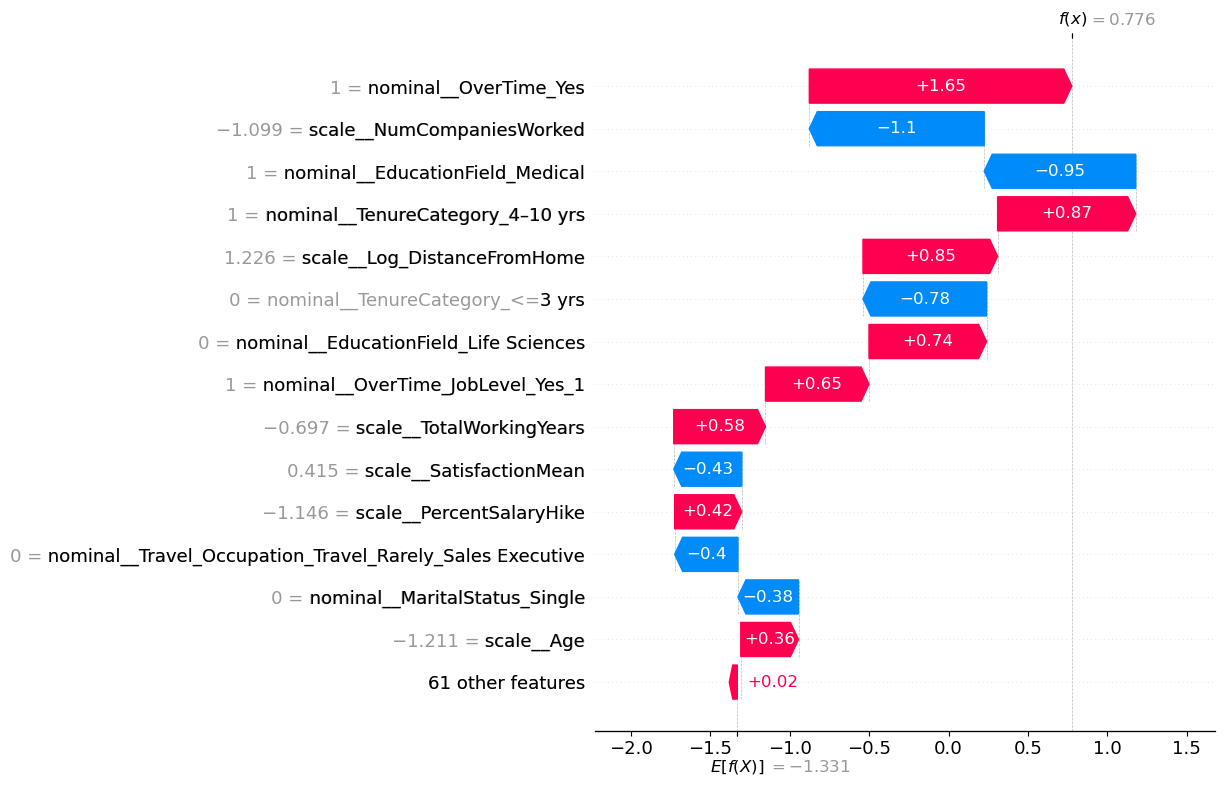

Index: 146, Prob: 0.776, Label @0.5: 1, Label @best: 0


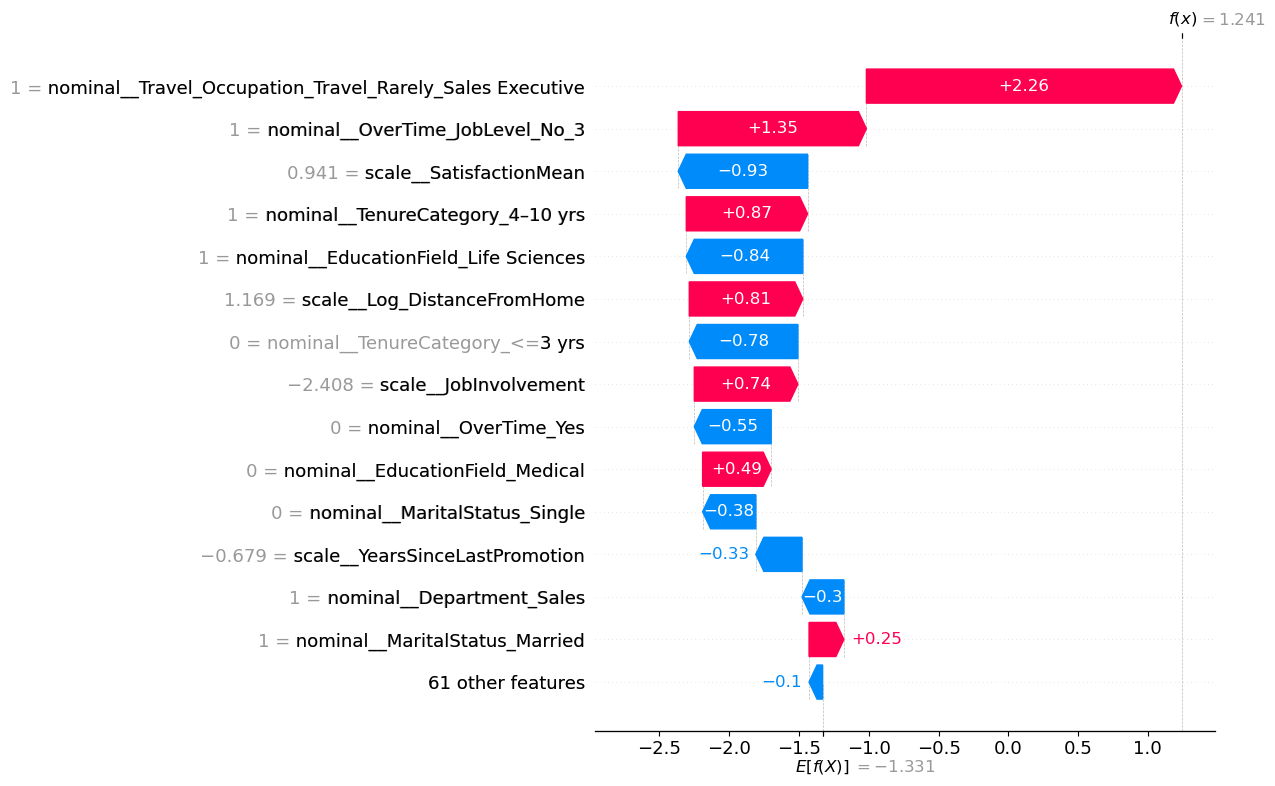

In [8]:
# SHAP waterfall plots for selected flipped samples
for idx in flipped_sample_ids:
    print(f"Index: {idx}, Prob: {y_prob[idx]:.3f}, Label @0.5: {y_pred_05[idx]}, Label @best: {y_pred_best[idx]}")
    shap.plots.waterfall(shap_values[idx], max_display=15)

## Coefficient-Based Interpretation (Logistic Regression)

This chart displays the coefficients from the logistic regression model, which quantify how each input feature influences the log-odds of employee attrition. 

- **Positive coefficients** (red bars) increase the log-odds of leaving the company.
- **Negative coefficients** (blue bars) decrease the log-odds—suggesting retention.

Because logistic regression is a linear model, coefficients provide direct interpretability: they reflect the isolated impact of each feature, holding all else constant.

### Preliminary Insights
- Features like **EducationField_Technical Degree**, **JobRole_Research Scientist**, and **BusinessTravel_Non-Travel** are associated with higher attrition odds.
- On the other hand, **JobRole_Healthcare Representative**, **JobRole_Manager**, and **BusinessTravel_Travel_Rarely** show strong negative associations, indicating possible retention factors.
- A number of features cluster around zero (e.g., **Gender**, **EducationField_Other**, **JobRole_Human Resources**), implying minimal influence or strong multicollinearity.

These coefficients serve as a transparent baseline for explaining the model’s decisions and build a foundation for comparison with SHAP values in the next section. While SHAP will offer instance-level explanations and interaction effects, the coefficient plot here helps us understand general directional trends and which features the model relies on most linearly.

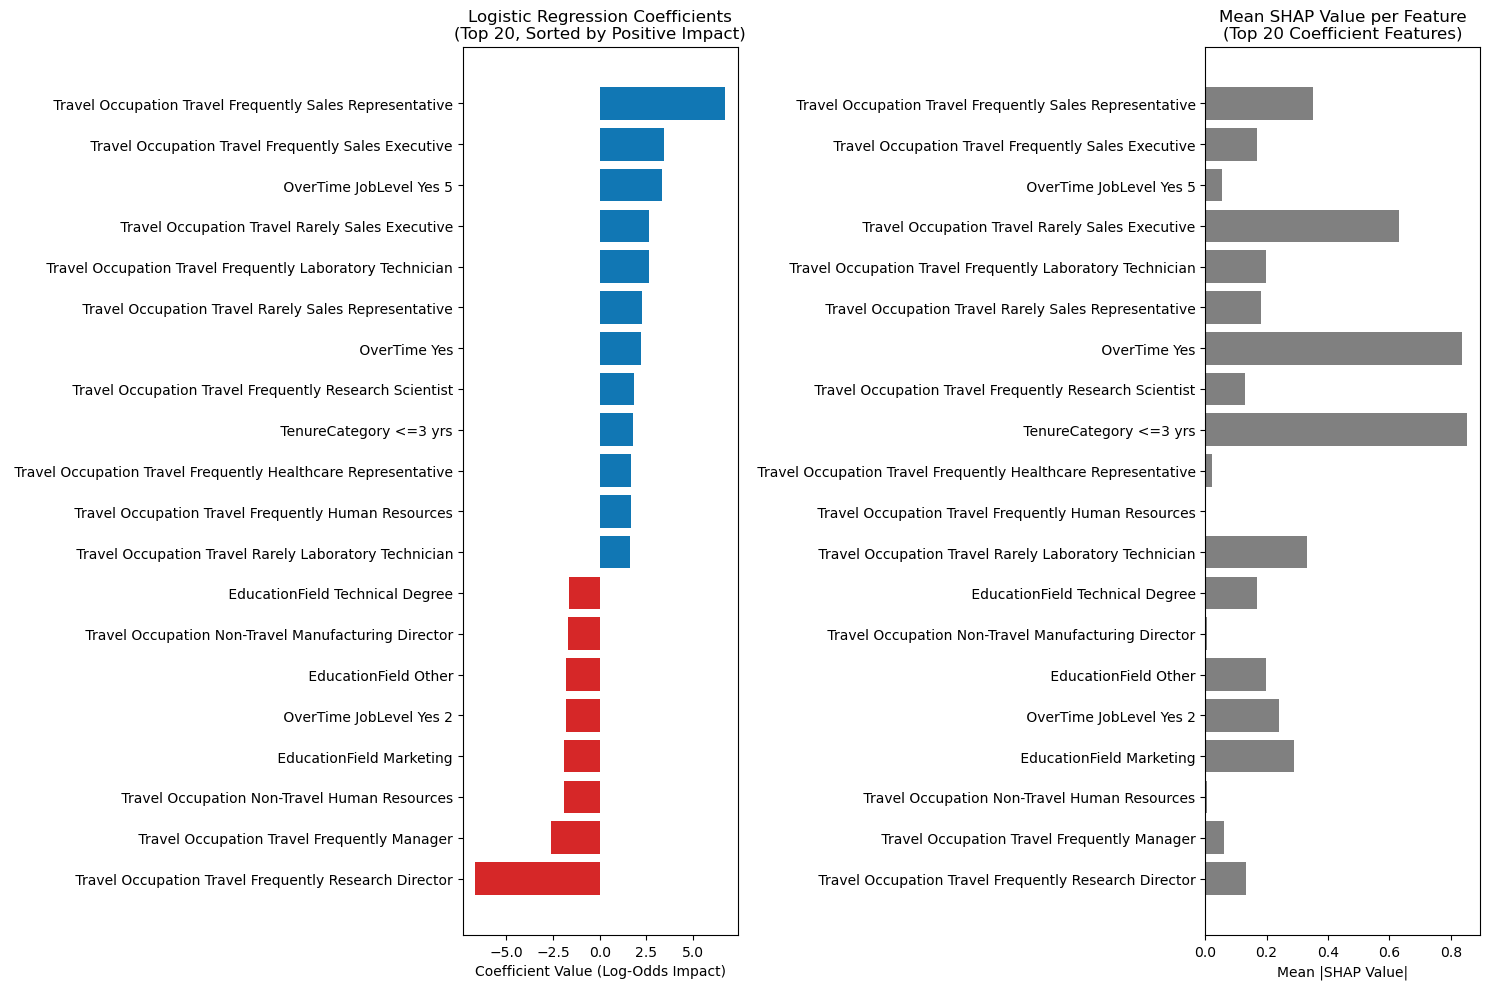

Model intercept: -3.566


In [17]:
# === Imports ===
import joblib
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import shap

# === Load Model, Data, and SHAP Values ===
classifier = joblib.load("../models/final_model.joblib")
X_transformed = pd.read_csv("../data/processed/x_test_transformed.csv")

with open("../models/x_test_columns.json", "r") as f:
    transformed_feature_names = json.load(f)

# === Clean Feature Names ===
def clean_name(name):
    return name.replace("nominal_", "").replace("scale_", "").replace("passthrough_", "").replace("_", " ")

# === SHAP Values ===
explainer = shap.Explainer(classifier, X_transformed, feature_names=transformed_feature_names)
shap_values = explainer(X_transformed)

# === Coefficients from Model ===
coefs = classifier.coef_[0]
intercept = classifier.intercept_[0]

coef_df = pd.DataFrame({
    "Feature": transformed_feature_names,
    "Coefficient": coefs
})
coef_df["AbsCoefficient"] = coef_df["Coefficient"].abs()

# === Grouping Logic ===
def extract_group(name):
    if "Travel" in name:
        return "Travel"
    elif "OverTime" in name:
        return "OverTime"
    elif "Department" in name:
        return "Department"
    elif "Satisfaction" in name or "Involvement" in name:
        return "Satisfaction"
    elif "JobRole" in name:
        return "Job Role"
    elif "Education" in name or "Field" in name:
        return "Education"
    elif "Income" in name or "Salary" in name or "Rate" in name:
        return "Compensation"
    elif "Years" in name or "Tenure" in name:
        return "Tenure"
    else:
        return "Other"

coef_df["Group"] = coef_df["Feature"].apply(extract_group)
coef_df["CleanFeature"] = coef_df["Feature"].apply(clean_name)

# === Top 20 Features by Coefficient Impact ===
top_coef_df = coef_df.sort_values(by="AbsCoefficient", ascending=False).head(20)
top_coef_df = top_coef_df.sort_values(by="Coefficient", ascending=False)

# === SHAP Mean Impact ===
mean_shap = np.abs(shap_values.values).mean(axis=0)
shap_df = pd.DataFrame({
    "Feature": transformed_feature_names,
    "MeanSHAP": mean_shap
})
shap_df["Group"] = shap_df["Feature"].apply(extract_group)
shap_df["CleanFeature"] = shap_df["Feature"].apply(clean_name)

# === Merge and keep clean labels ===
merged_df = pd.merge(top_coef_df, shap_df[["Feature", "MeanSHAP", "Group", "CleanFeature"]], on="Feature", how="left")
merged_df = merged_df.sort_values(by="Coefficient", ascending=False)

merged_df["CleanFeature"] = merged_df["Feature"].apply(clean_name)

# === Plot side by side ===
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# Use the shared CleanFeature for both plots
labels = merged_df["CleanFeature"]

# --- Coefficient Plot ---
axes[0].barh(
    labels,
    merged_df["Coefficient"],
    color=["#1177b4" if c > 0 else "#d62728" for c in merged_df["Coefficient"]]
)
axes[0].set_title("Logistic Regression Coefficients\n(Top 20, Sorted by Positive Impact)")
axes[0].set_xlabel("Coefficient Value (Log-Odds Impact)")
axes[0].invert_yaxis()

# --- SHAP Plot ---
axes[1].barh(
    labels,
    merged_df["MeanSHAP"],
    color="gray"
)
axes[1].set_title("Mean SHAP Value per Feature\n(Top 20 Coefficient Features)")
axes[1].set_xlabel("Mean |SHAP Value|")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

# Optional: print model intercept
print(f"Model intercept: {intercept:.3f}")


## ✅ Final Summary: Model Explainability and Interpretation

In this notebook, we explored model explainability using SHAP to understand how and why our attrition prediction model makes its decisions. The analysis focused on both **global** and **local** interpretations, as well as how predictions shift when adjusting the classification threshold.

---

### 🔍 Global Insights

Using SHAP summary plots:
- The most important drivers of attrition were:
  - `NumCompaniesWorked`
  - `TotalWorkingYears`
  - `YearsWithCurrManager`
  - `EnvironmentSatisfaction` and `RelationshipSatisfaction`
- Violin plots revealed that:
  - High values for `NumCompaniesWorked` and low satisfaction scores tended to **increase attrition risk**
  - Stable and longer-tenured employees were **less likely to leave**

These insights support actionable HR strategies — for example, flagging employees with recent job changes or low satisfaction for retention interventions.

---

### 👤 Local Explanations

Using SHAP waterfall plots:
- We examined specific individuals predicted to **leave**, **stay**, or sit **near the decision boundary**
- These plots clearly showed which features pushed predictions in each direction
- Local explanations are critical for transparency, especially for edge cases that may warrant manual review

---

### 🎯 Threshold Effects

We compared the model’s predictions at:
- Default threshold = 0.5
- Optimal threshold (determined by F1 score)

Key takeaways:
- Adjusting the threshold significantly changes the **confusion matrix**, improving balance between false positives and false negatives
- SHAP explanations for flipped predictions clarified the trade-offs involved
- This helps decision-makers choose thresholds aligned with business priorities (e.g., cost of false negatives)

---

### ✅ Conclusion

By combining **model predictions** with **explainability techniques**, we ensure that:
- The model is not a black box
- Stakeholders can trust and act on its outputs
- Critical decisions — such as employee outreach or retention investment — are supported by transparent, data-driven reasoning

This notebook demonstrates the use of SHAP not only as a technical tool, but as a bridge between machine learning performance and human understanding.
